In [2]:
# 1) Import Libraries and Check CUDA

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import optuna

# Check if CUDA is available
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Is CUDA supported by this system? True


In [2]:
# 2) Load and Preprocess the Data

# Load the data
data = pd.read_csv('MSFT.csv', parse_dates=['Date'])
data = data[(data['Date'] >= '1987-01-01') & (data['Date'] <= '2021-12-31')]
data = data[['Date', 'Close']]

# Normalize and convert to numpy array
prices = ((data['Close'] - data['Close'].mean()) / data['Close'].std()).values

# Define training, validation, and test intervals
training_start = '1987-01-01'
training_end = '2013-12-31'

validation_start = '2014-01-01'
validation_end = '2017-12-31'

test_start = '2018-01-01'
test_end = '2021-12-31'

# Create training, validation, and test indices
train_indices = ((data['Date'] >= training_start) & (data['Date'] <= training_end)).values
validation_indices = ((data['Date'] >= validation_start) & (data['Date'] <= validation_end)).values
test_indices = ((data['Date'] >= test_start) & (data['Date'] <= test_end)).values

In [3]:
# 3) Define a Dataset Class

class StockDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length
    
    def __len__(self):
        return len(self.data) - self.seq_length
    
    def __getitem__(self, index):
        x = self.data[index:index+self.seq_length]
        y = self.data[index+self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [4]:
# 4) Define the Model

# Define a model with 5 layers as follows: LSTM, LSTM, Dense, Dense, Dense
class StockPricePredictor(nn.Module):
    def __init__(self, input_size=1, hidden1_size=256, hidden2_size=256, dense1_size=128, dense2_size=64):
        super(StockPricePredictor, self).__init__()
        self.hidden1_size = hidden1_size
        self.hidden2_size = hidden2_size
        
        self.lstm1 = nn.LSTM(input_size, hidden1_size, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(hidden1_size, hidden2_size, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(hidden2_size, dense1_size)
        self.fc2 = nn.Linear(dense1_size, dense2_size)
        self.fc3 = nn.Linear(dense2_size, 1)
        
    def forward(self, x):
        h0_1 = torch.zeros(1, x.size(0), self.hidden1_size).to(x.device)
        c0_1 = torch.zeros(1, x.size(0), self.hidden1_size).to(x.device)
        out, _ = self.lstm1(x, (h0_1, c0_1))
        
        h0_2 = torch.zeros(1, out.size(0), self.hidden2_size).to(x.device)
        c0_2 = torch.zeros(1, out.size(0), self.hidden2_size).to(x.device)
        out, _ = self.lstm2(out, (h0_2, c0_2))
        
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [5]:
# 5) Define the Objective Function for Optuna

def objective(trial):
    # Suggest values for the hyperparameters
    seq_length    = trial.suggest_int('seq_length', 10, 60)
    hidden1_size  = trial.suggest_int('hidden1_size', 32, 256)
    hidden2_size  = trial.suggest_int('hidden2_size', 32, 256)
    dense1_size   = trial.suggest_int('dense1_size', 32, 128)
    dense2_size   = trial.suggest_int('dense2_size', 16, 64)
    num_epochs    = trial.suggest_int('num_epochs', 10, 200)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    
    # Create training and validation datasets and dataloaders
    train_dataset = StockDataset(prices[train_indices], seq_length)
    validation_dataset = StockDataset(prices[validation_indices], seq_length)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)
    
    # Initialize the model with suggested hyperparameters
    model = StockPricePredictor(1, hidden1_size, hidden2_size, dense1_size, dense2_size).to(device)
    
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train the model
    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.unsqueeze(-1)
            outputs = model(inputs).squeeze(-1)
            
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    # Evaluate the model for validaiton loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in validation_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.unsqueeze(-1)
            outputs = model(inputs).squeeze(-1)

            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    # Return the validation loss of the trained model
    val_loss /= len(validation_loader)
    return val_loss

In [6]:
# 6) Optimize Hyperparameters with Optuna

# Optimize hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

# Print the best parameters
print('Best parameters: ', study.best_params)

[I 2024-07-15 23:42:39,316] A new study created in memory with name: no-name-5376d718-f6a1-400b-aea5-c68b9c3587b5
[I 2024-07-15 23:42:54,605] Trial 0 finished with value: 0.0019838242915284354 and parameters: {'seq_length': 22, 'hidden1_size': 154, 'hidden2_size': 137, 'dense1_size': 76, 'dense2_size': 31, 'num_epochs': 21, 'learning_rate': 0.0037004523758145326}. Best is trial 0 with value: 0.0019838242915284354.
[I 2024-07-15 23:43:55,446] Trial 1 finished with value: 0.000502073862207908 and parameters: {'seq_length': 20, 'hidden1_size': 151, 'hidden2_size': 61, 'dense1_size': 97, 'dense2_size': 60, 'num_epochs': 101, 'learning_rate': 0.0027002837565786677}. Best is trial 1 with value: 0.000502073862207908.
[I 2024-07-15 23:44:10,890] Trial 2 finished with value: 0.001274500824365532 and parameters: {'seq_length': 19, 'hidden1_size': 125, 'hidden2_size': 146, 'dense1_size': 51, 'dense2_size': 56, 'num_epochs': 30, 'learning_rate': 9.018609345582277e-05}. Best is trial 1 with value: 

Best parameters:  {'seq_length': 11, 'hidden1_size': 188, 'hidden2_size': 110, 'dense1_size': 63, 'dense2_size': 36, 'num_epochs': 125, 'learning_rate': 0.0002866772081238035}


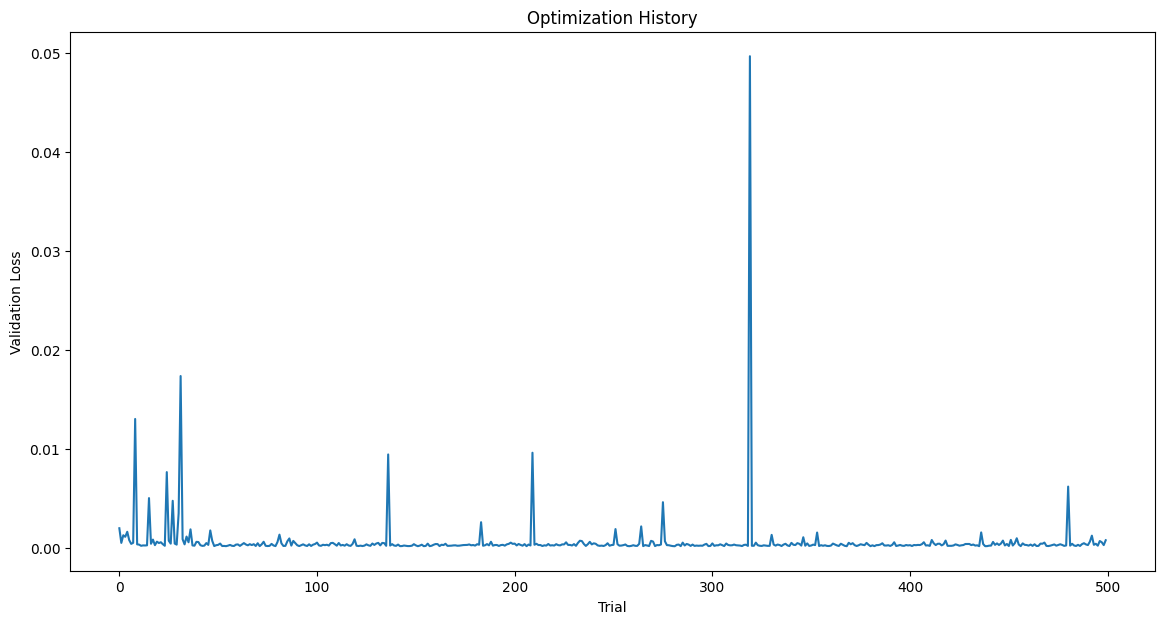

In [7]:
# 7) Plot Hyperparameter Optimization History

fig = plt.figure(figsize=(14, 7))
plt.plot(study.trials_dataframe().number, study.trials_dataframe().value)
plt.xlabel('Trial')
plt.ylabel('Validation Loss')
plt.title('Optimization History')
plt.show()

In [8]:
# 8) Train the Model with Optimized Parameters

# Extract optimized parameters
best_params =   study.best_params
seq_length =    best_params['seq_length']
hidden1_size =  best_params['hidden1_size']
hidden2_size =  best_params['hidden2_size']
dense1_size =   best_params['dense1_size']
dense2_size =   best_params['dense2_size']
num_epochs =    best_params['num_epochs']
learning_rate = best_params['learning_rate']

# Create training and validation datasets and dataloaders
train_dataset = StockDataset(prices[train_indices], seq_length)
validation_dataset = StockDataset(prices[validation_indices], seq_length)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)

# Initialize the model with optimized parameters
model = StockPricePredictor(1, hidden1_size, hidden2_size, dense1_size, dense2_size).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.unsqueeze(-1)
        outputs = model(inputs).squeeze(-1)
        loss = criterion(outputs, targets)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Evaluate on validation set
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in validation_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.unsqueeze(-1)
            outputs = model(inputs).squeeze(-1)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    val_loss /= len(validation_loader)
    val_losses.append(val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.8f}, Val Loss: {val_loss:.8f}')

Epoch [1/125], Train Loss: 0.02600236, Val Loss: 0.08217100
Epoch [2/125], Train Loss: 0.00052209, Val Loss: 0.00333076
Epoch [3/125], Train Loss: 0.00039226, Val Loss: 0.00390678
Epoch [4/125], Train Loss: 0.00037924, Val Loss: 0.00504382
Epoch [5/125], Train Loss: 0.00037250, Val Loss: 0.00322362
Epoch [6/125], Train Loss: 0.00035652, Val Loss: 0.00096690
Epoch [7/125], Train Loss: 0.00035846, Val Loss: 0.00100619
Epoch [8/125], Train Loss: 0.00034506, Val Loss: 0.00250384
Epoch [9/125], Train Loss: 0.00033468, Val Loss: 0.00429812
Epoch [10/125], Train Loss: 0.00032656, Val Loss: 0.00082342
Epoch [11/125], Train Loss: 0.00030536, Val Loss: 0.00056026
Epoch [12/125], Train Loss: 0.00028730, Val Loss: 0.00068632
Epoch [13/125], Train Loss: 0.00026996, Val Loss: 0.00050390
Epoch [14/125], Train Loss: 0.00026287, Val Loss: 0.00102442
Epoch [15/125], Train Loss: 0.00024357, Val Loss: 0.00080646
Epoch [16/125], Train Loss: 0.00022553, Val Loss: 0.00056193
Epoch [17/125], Train Loss: 0.000

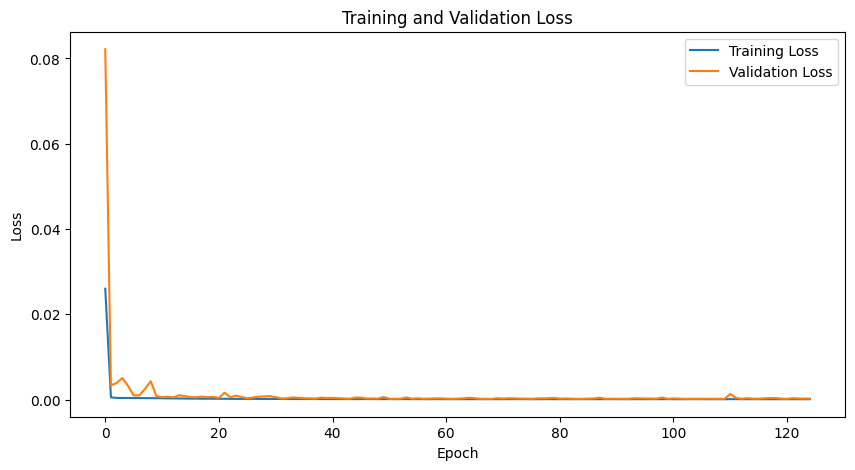

In [9]:
# 9) Plot Training and Validation Loss

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [10]:
# 10) Make Predictions on Training, Validation, and Test Data

model.eval()

# Make predictions on the training data
train_predictions = []
train_actuals = []

with torch.no_grad():
    for inputs, targets in DataLoader(train_dataset, batch_size=1, shuffle=False):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.unsqueeze(-1)
        outputs = model(inputs).squeeze(-1)
        train_predictions.append(outputs.item())
        train_actuals.append(targets.item())

# Make predictions on the validation data
validation_predictions = []
validation_actuals = []

with torch.no_grad():
    for inputs, targets in DataLoader(validation_dataset, batch_size=1, shuffle=False):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.unsqueeze(-1)
        outputs = model(inputs).squeeze(-1)
        validation_predictions.append(outputs.item())
        validation_actuals.append(targets.item())

# Make predictions on the test data
test_dataset = StockDataset(prices[test_indices], seq_length)
test_predictions = []
test_actuals = []

with torch.no_grad():
    for inputs, targets in DataLoader(test_dataset, batch_size=1, shuffle=False):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.unsqueeze(-1)
        outputs = model(inputs).squeeze(-1)
        test_predictions.append(outputs.item())
        test_actuals.append(targets.item())

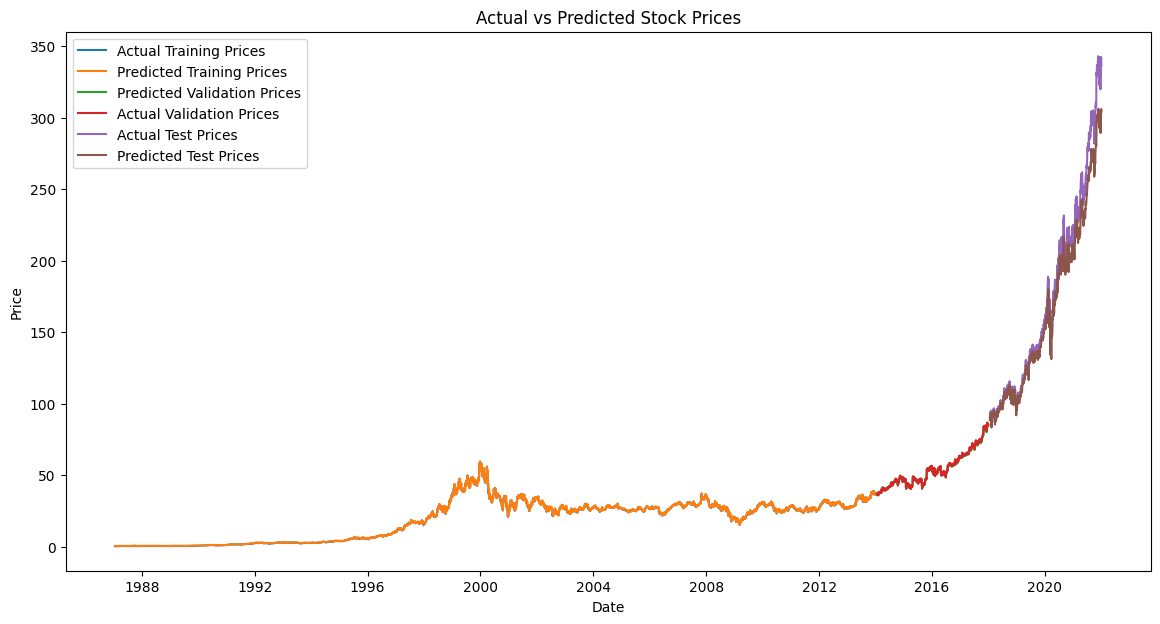

In [11]:
# 11) Plot Actual vs Predicted Prices

# Convert normalized values back to original scale
train_actuals = np.array(train_actuals) * data['Close'].std() + data['Close'].mean()
train_predictions = np.array(train_predictions) * data['Close'].std() + data['Close'].mean()

validation_predictions = np.array(validation_predictions) * data['Close'].std() + data['Close'].mean()
validation_actuals = np.array(validation_actuals) * data['Close'].std() + data['Close'].mean()

test_actuals = np.array(test_actuals) * data['Close'].std() + data['Close'].mean()
test_predictions = np.array(test_predictions) * data['Close'].std() + data['Close'].mean()

# Create date ranges for plotting
train_dates = data['Date'][train_indices][seq_length:]
validation_dates = data['Date'][validation_indices][seq_length:]
test_dates = data['Date'][test_indices][seq_length:]

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(train_dates, train_actuals, label='Actual Training Prices')
plt.plot(train_dates, train_predictions, label='Predicted Training Prices')
plt.plot(validation_dates, validation_predictions, label='Predicted Validation Prices')
plt.plot(validation_dates, validation_actuals, label='Actual Validation Prices')
plt.plot(test_dates, test_actuals, label='Actual Test Prices')
plt.plot(test_dates, test_predictions, label='Predicted Test Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()